import the well log data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import lasio
import numpy as np


data=lasio.read("KG-17_wireline_data_final_spliced.las")
well=data.df()
well.reset_index(inplace=True)
a=32881;b=36167         #depth 5 to 5.5Km(reserver zone)
well=well[a:b]

C:\Users\malay\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Remove all -ve and Nan values

In [2]:
# nan_mask = well.isnull()
# negative_mask = well < 0
# invalid_rows_mask = nan_mask.any(axis=1) | negative_mask.any(axis=1)
# well= well[~invalid_rows_mask]

Found parameters from well log data

In [3]:
vp= (1.0 / well['DTCO'] )*304.800
vs= (1.0 / well['DTSM'])*304.800
mu_rho=well["RHOZ"]*vs**2
lamda_rho=well['RHOZ']*vp**2-4*mu_rho/3


In [4]:
rho_o = 42.0  # Oil gravity (deg API)
GOR = 160.0  # GOR (L/L)
rho_g = 0.9  # Gas gravity (API)
# rho_g = 0.554  # Specific gravity of mithen (uncomment if needed)
# rho_g = 1.52  # Specific gravity of carbon dioxide (uncomment if needed)
T = 150.00  # Temperature (0 C)
P = 3200.00  # Pressure (psi) 1 MPa=145.0377 psi
P=10152.639 #psi(real data)
S = 3800  # Water salinity (ppm)

phi=(2.71-well["RHOZ"])/(2.71-1.03)
# vsh = (well["HSGR"]-np.min(well["HSGR"]))/(np.max(well["HSGR"])-np.min(well["HSGR"]))
vsh = (well["HSGR"]-40)/(170-40)
phi = phi.clip(lower=0)                 ##all negative valuesof phi replaced by zeros


Choices

In [5]:
wa=1
isw =  np.full(len(vsh),wa)
ifluid = 2  # Desired fluid is 1(brine), 2(oil), 3(gas)
fluid=2


In [6]:
rho = well["RHOZ"]    # gm/cc - from log (initial value)
k_clay = 20.9  # Bulk mod (GPa)
k_qtz = 36.6
rho_clay = 2.58  # gm/cc
rho_qtz = 2.65


In [7]:
div_mill = 1 / 1000000  # factor used to divide by million
cl = 0.7
v_clay = vsh * cl  # Assumption: V_clay = 70% of VSH
v_qtz = 1 - v_clay  # quartz fraction in mineral
ish = 1 - isw  # initial hydrocarbon saturation

rho_o = 141.5 / (rho_o + 131.5)  # oil gravity in gm/cc (from API)
P = P * 6.894757 * 0.001  # Press in MPa (from Psi)
S = S * div_mill  # salinity as weight fraction

In [8]:
# Step 1: Matrix properties (using VRH averaging, equation 6)
k_voigt = v_clay * k_clay + v_qtz * k_qtz
k_reuss = 1 / (v_clay / k_clay + v_qtz / k_qtz)
k_matrix = 0.5 * (k_voigt + k_reuss)  # GPa
rho_matrix = v_clay * rho_clay + v_qtz * rho_qtz  # gm/cc
# rho_matrix=2.71


# Step 2: water/brine properties (Equations 10 and 11)
w = [
    [1402.85, 1.524, 3.437e-3, -1.197e-5],
    [4.871, -0.0111, 1.739e-4, -1.628e-6],
    [-0.04783, 0.0002747, -2.135e-6, 1.237e-8],
    [1.487e-4, -6.503e-7, -1.455e-8, 1.327e-10],
    [-2.197e-7, 7.987e-10, 5.23e-11, -4.614e-13]
]

sum_value = 0

for i in range(5):
    for j in range(4):
        sum_value += w[i][j] * (T ** i) * (P ** j)

v_water = sum_value
v1 = 1170 - 9.6 * T + 0.055 * T ** 2 - 8.5e-5 * T ** 3 + 2.6 * P - 0.0029 * T * P - 0.0476 * P ** 2
v_brine = v_water + S * v1 + S ** 1.5 * (780 - 10 * P + 0.16 * P ** 2) - 1820 * S ** 2
r1 = 489 * P - 2 * T * P + 0.016 * T ** 2 * P - 1.3e-5 * T ** 3 * P - 0.333 * P ** 2 - 0.002 * T * P ** 2
rho_water = 1 + 1e-6 * (-80 * T - 3.3 * T ** 2 + 0.00175 * T ** 3 + r1)
r2 = 300 * P - 2400 * P * S + T * (80 + 3 * T - 3300 * S - 13 * P + 47 * P * S)
rho_brine = rho_water + 0.668 * S + 0.44 * S ** 2 + 1e-6 * S * r2  # gm/cc (held const)
k_brine = rho_brine * v_brine ** 2 * div_mill  # GPa (held const)


def found_fluid(fluid):
    if fluid==1:
        k_hyc = k_brine
        rho_hyc = rho_brine
        return [rho_hyc,k_hyc]
    elif fluid == 2:  # Oil
        B0 = 0.972 + 0.00038 * (2.495 * GOR * (rho_g / rho_o) ** 0.5 + T + 17.8) ** 1.175
        rho_ps = rho_o / ((1 + 0.001 * GOR) * B0)
        rho_s = (rho_o + 0.0012 * GOR * rho_g) / B0
        r1 = rho_s + (0.00277 * P - 1.71e-7 * P ** 3) * (rho_s - 1.15) ** 2 + 3.49e-4 * P
        rho_hyc = r1 / (0.972 + 3.81e-4 * (T + 17.78) ** 1.175)  # gm/cc (will change)
        v = 2096 * (rho_ps / (2.6 - rho_ps)) ** 0.5 - 3.7 * T + 4.64 * P + 0.0115 * ((18.33 / rho_ps) ** 0.5 - 4.98) * T * P
        k_hyc = rho_hyc * v ** 2 * div_mill  # GPa (will change)
        return [rho_hyc,k_hyc]
    else:  # Gas
        R = 8.314  # gas constant
        Ta = T + 273.15
        Ppr = P / (4.892 - 0.4048 * rho_g)
        Tpr = Ta / (94.72 + 170.75 * rho_g)
        E1 = np.exp(-((Ppr ** 1.2) / Tpr) * (0.45 + 8 * (0.56 - 1 / Tpr) ** 2))
        E = 0.109 * E1 * (3.85 - Tpr) ** 2
        Z1 = 0.03 + 0.00527 * (3.5 - Tpr) ** 3
        Z = Z1 * Ppr + 0.642 * Tpr - 0.007 * Tpr ** 4 - 0.52 + E
        rho_hyc = 28.8 * rho_g * P / (Z * R * Ta)
        dz_dp = Z1 + 0.109 * (3.85 - Tpr) ** 2 * E1 * (-1.2 * (Ppr ** 0.2 / Tpr) * (0.45 + 8 * (0.56 - 1 / Tpr) ** 2))
        yo = 0.85 + 5.6 / (Ppr + 2) + 27.1 / (Ppr + 3.5) ** 2 - 8.7 * np.exp(-0.65 * (Ppr + 1))
        k_hyc = P * (yo / 1000) * 1.0 / (1 - (Ppr / Z) * dz_dp)  # GPa
        return [rho_hyc,k_hyc]


# Step 4: Fluid properties (initial in-situ model, equations 30 and 31)
k_hyd=found_fluid(ifluid)[1]
rho_hyd=found_fluid(ifluid)[0]
k_fl = 1 / (isw / k_brine + ish / k_hyd)
rho_fl = isw * rho_brine + ish * rho_hyd



# Step 5: In-situ original moduli (for saturated – in-situ rock, equations 4 and 5)
dens_poros = 0  # 1 (use porosity to estimate initial density), 0 (use input log)
if dens_poros == 1:
    rho = phi * rho_fl + (1 - phi) * rho_matrix

k_sat = rho * (vp ** 2 - (4*vs ** 2 ) / 3)  # GPa (will change in step 9)
g = rho * vs ** 2  # GPa (held constant)


# Step 6: Porous frame properties (rewrite Gassmann eqn, equation 36)
k1 = k_sat * (phi * k_matrix / k_fl + 1 - phi) - k_matrix
k2 = phi * k_matrix / k_fl + k_sat / k_matrix - 1 - phi
k_frame = k1 / k2  # GPa (held constant)

filtering of K_frame

In [9]:
# k_frame = k_frame.clip(lower=-25, upper=50)           
print(k_frame.describe())
k_frame=np.mean(k_frame)


count    3176.000000
mean       14.630468
std       174.600147
min     -9752.336214
25%        11.485896
50%        18.435606
75%        25.619088
max       253.979497
dtype: float64


Operation start

In [10]:

a=[.001,.1,.2,.3,.4,.5,.6,.7,.8,.9]         #water saturations
k_hyd=found_fluid(fluid)[1]
rho_hyd=found_fluid(fluid)[0]


Calculated V_p

In [11]:
#step 7
# Step 8: Fluid properties (target saturation) and saturated rock density (equations 30 and 31)
Vp=np.zeros((len(a),len(vsh)))
j=0
for i in a:
    tsw =  np.full(len(vsh),i)
    tsh=1-tsw
    k_fl = 1 / (tsw / k_brine + tsh / k_hyd)
    rho_fl = tsw * rho_brine + tsh * rho_hyd
    rho_sat = phi * rho_fl + (1 - phi) * rho_matrix  # gm/cc (OUTPUT)
    
# Step 9: Gassmann Saturated bulk modulus (equation 3)
    k1 = phi / k_fl + (1 - phi) / k_matrix - k_frame / (k_matrix * k_matrix)
    k_sat_new = k_frame + ((1 - k_frame / k_matrix) ** 2) / k1
    
# Step 10: Seismic velocity after fluid substitution (equations 1 and 2)
    vp_sat = np.sqrt((k_sat_new + mu_rho * 4 / 3) / rho_sat) 
    vs_sat = np.sqrt(mu_rho / rho_sat)
    Vp[j,:]=vp_sat
    j+=1

C:\Users\malay\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


For get exact vp

In [12]:
vp_exact= np.zeros(len(vp), dtype=Vp.dtype) 
wat_sat=np.zeros(len(vp), dtype=Vp.dtype) 
#argmin(): this give the index fo minimum value
for i, value in enumerate(vp):
    nearest_index = np.abs(Vp[:, i] - value).argmin()  
    vp_exact[i] = Vp[nearest_index, i]
    wat_sat[i]=a[nearest_index]

For plot

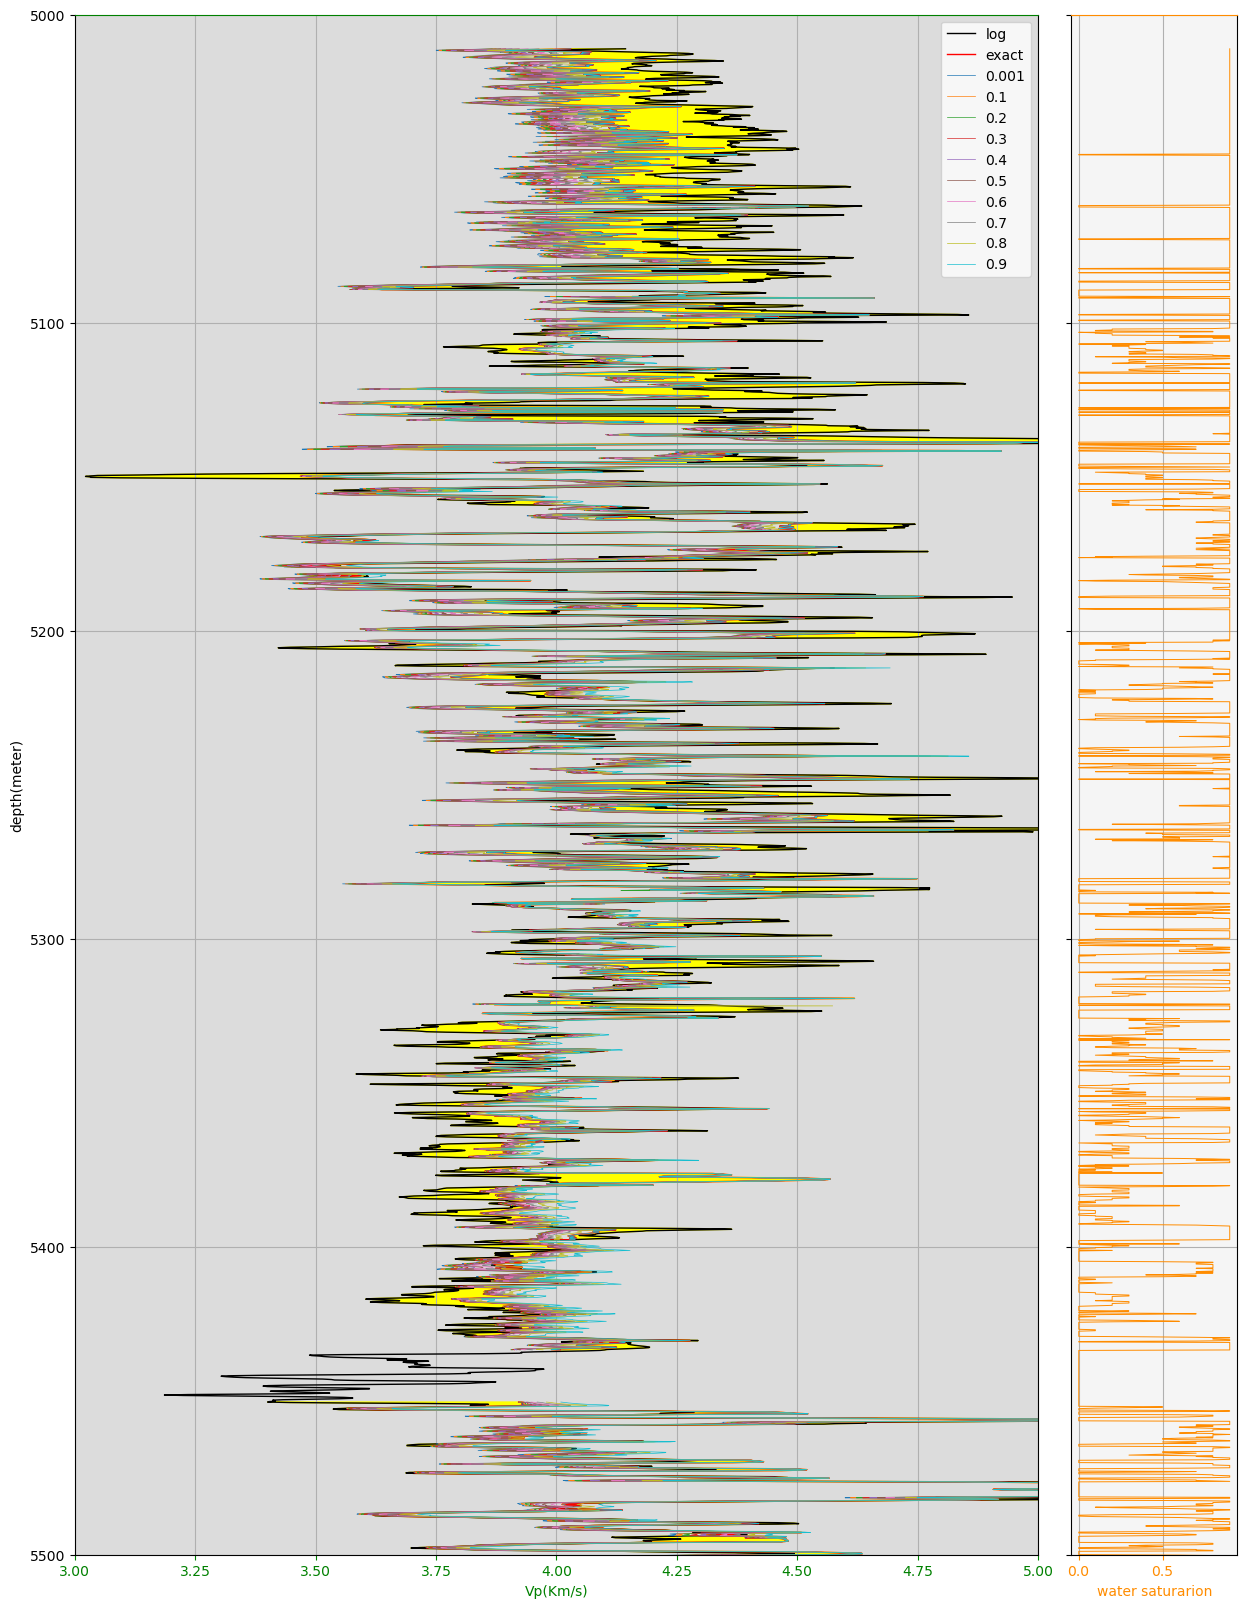

In [13]:
fig = plt.figure(figsize=(15, 20))
# Set up the plot axes
ax2= plt.subplot2grid((1,6), (0,5),rowspan=1, colspan=1)
ax1 = plt.subplot2grid((1,6), (0,0),rowspan=1, colspan=5,sharey=ax2)


c1="darkorange"
ax2.plot(wat_sat, well['DEPTH'], color=c1, lw=.7)
ax2.set_xlabel("water saturarion")
ax2.yaxis.set_tick_params(labelleft=False)  # Hide y-axis label on ax2
ax2.xaxis.label.set_color(c1)
ax2.tick_params(axis='x', colors=c1)
ax2.spines["top"].set_edgecolor(c1)

ax1.plot(vp, well['DEPTH'], color="k", lw=1,label="log")
ax1.plot(vp_exact, well['DEPTH'], color="red", lw=1,label="exact")
for i in range(len(a)):
    ax1.plot(Vp[i,:],well["DEPTH"],label=a[i],lw=.5)
    

ax1.set_xlabel("Vp(Km/s)")
miny=5350;maxy=5400
miny=5000;maxy=5500

ax1.set_xlim(3,5)
ax1.set_ylim(maxy,miny)
ax2.set_ylim(maxy,miny)
ax1.xaxis.label.set_color("green")
ax1.tick_params(axis='x', colors="green")
ax1.spines["top"].set_edgecolor("green")
ax1.set_ylabel("depth(meter)")
ax1.legend()

# ax1.set_title(f"$isw = {wa}, hyd=C_nH_n (\\rho_{{g}}={rho_g})$")
# ax1.set_title("water saturation")
ax1.grid(True)
ax2.grid(True)

#give the background colors
# fig.patch.set_facecolor('gainsboro')
ax1.set_facecolor('gainsboro')
ax2.set_facecolor('whitesmoke')
ax1.fill_betweenx(well['DEPTH'], vp_exact,vp,color="yellow")

plt.show()

Hydrocarbon Saturation from model

In [14]:
k1_sat=well['RHOZ']*vp_exact**2-4*mu_rho/3
k1_fl=phi/((1-k_frame/k_matrix)**2/(k1_sat-k_frame)-((1-phi)/k_matrix)+(k_frame/k_matrix**2))
v1_hyd=(k_hyd*(k_brine/k1_fl-1)/(k_brine-k_hyd))

In [15]:
well[(5117<=well['DEPTH'])&(5122<=(well['DEPTH']))]

,DEPTH,BS,CALI,DEPRES,DRHO,DTCO,DTSM,HCGR,HSGR,MEDRES,NEUTRON,PEFZ,RHOZ,SHALORES
33609,5122.0116,8.5,9.7632,8.059400,-0.0056,69.4623,133.0262,141.0973,160.2877,7.344200,0.1335,8.4084,2.7238,6.1090
33610,5122.1640,8.5,9.9357,9.055600,-0.0150,68.8499,131.0820,154.0343,169.7461,10.931300,0.1294,6.7245,2.6955,9.0725
33611,5122.3164,8.5,9.7241,6.921600,-0.0141,69.4192,129.9406,175.6456,189.0493,11.040200,0.1369,6.0371,2.6553,9.4610
33612,5122.4688,8.5,9.7469,6.462299,-0.0149,69.1689,128.6705,191.7237,208.3449,7.481200,0.1379,5.5246,2.6170,7.0582
33613,5122.6212,8.5,9.8152,5.809800,-0.0119,68.6198,126.8972,186.0741,209.4254,6.299900,0.1391,5.1773,2.6070,6.3247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36162,5511.0888,8.5,8.2500,9.400000,-0.0750,71.2346,111.0415,86.4929,93.0848,9.510000,0.1120,NaN,2.6111,9.0200
36163,5511.2412,8.5,8.2500,9.330000,-0.0650,70.4828,109.8718,85.9987,90.8558,9.450000,0.1127,NaN,2.6148,8.9500
36164,5511.3936,8.5,8.2500,9.340000,-0.0650,69.3251,108.4531,86.3348,90.7389,9.450000,0.1108,NaN,2.6235,8.9600
36165,5511.5460,8.5,8.2500,9.540001,-0.0450,69.0095,108.0763,84.7558,91.1463,9.549999,0.1067,NaN,2.6295,9.1000


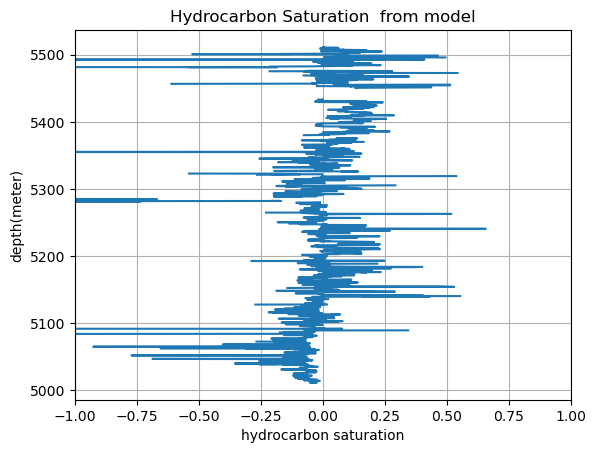

In [16]:
plt.plot(v1_hyd,well["DEPTH"])
plt.xlim(-1,1)
plt.xlabel("hydrocarbon saturation")
plt.ylabel("depth(meter)")
plt.title("Hydrocarbon Saturation  from model")
plt.grid()

Hydrocarbon saturation from log data

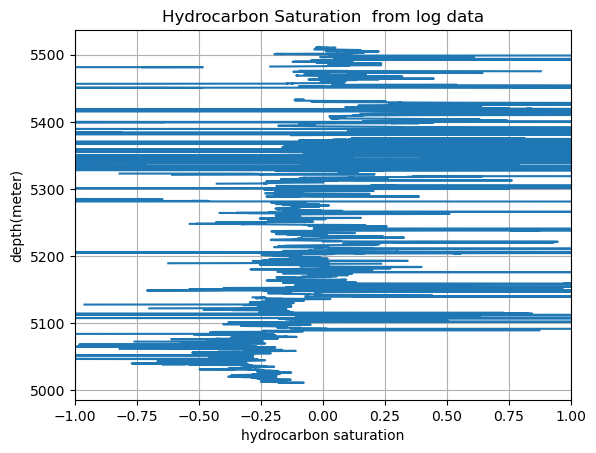

In [17]:
k2_sat=well['RHOZ']*vp**2-4*mu_rho/3
k2_fl=phi/((1-k_frame/k_matrix)**2/(k2_sat-k_frame)-((1-phi)/k_matrix)+(k_frame/k_matrix**2))
v2_hyd=(k_hyd*(k_brine/k2_fl-1)/(k_brine-k_hyd))

plt.plot(v2_hyd,well["DEPTH"])
plt.xlim(-1,1)
plt.xlabel("hydrocarbon saturation")
plt.ylabel("depth(meter)")
plt.title("Hydrocarbon Saturation  from log data")
plt.grid()